## Data Preparation

* Dataset Used: COCO dataset (https://cocodataset.org/#home)
* Objects used for classification
    - Bed
    - Car
    - Cell Phone
    - Chair
    - Microwave
    - Person
    - Refrigerator
    - Sink
    - Toilet
    - Umbrella
* How were images obtained?
    - Images were obtained using the pycoco API tools.
* How was dataset prepared?
    - PyCOCO API was used to retrieve images of the desired categories.
    - Since COCO images had multiple objects belonging to multiple categories, we used bounding boxes to extract only the relevant object.
    - All the annotations corresponding to the retrieved images were used to locate the bounding box of the desired object.
    - The bounding box was checked for properties such as area, height, and width.
    - Only those bounding boxes were chosen which met minimum area requirements and which has an acceptable aspect ratio.
    - The extracted object was reshaped to a (520 X 520 X 3) image and saved.
* Below is the script to generate the dataset. (The script used a pool of threads to speed up the data generation process)

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import os
from PIL import Image
from skimage.transform import resize
import multiprocessing as mp
from multiprocessing import Pool
import itertools

def get_images_wrapper(args):
    return get_images(*args)

# function to retrieve images of a given category and store them as numpy array
def get_images(category, coco, n_images = 1000, offset =  0):
    print("Starting to process {}...".format(category))
    images_dir = './data/{}'.format(category)
    
    # create a directory corresponding to a category
    if not os.path.exists(images_dir):
        os.mkdir(images_dir)
    
    # get all image ids and corresponding images containing given category
    catIds = coco.getCatIds(catNms = [category])
    imgIds = coco.getImgIds(catIds = catIds)

    # randomize the imgIds list
    random.shuffle(imgIds)

    # count to keep track of the number of valid images generated
    cnt = 0
    
    # list to store all images as numpy arrays
    X = []
    for imgId in imgIds:
        img = coco.loadImgs([imgId])[0]
        
        # use url to load image
        I = io.imread(img['coco_url'])
        
        # load annotations
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        
        # iterate over all annotations and extract bounding boxes
        for ann in anns:
            # if we have got the required number of images, we exit
            if cnt > n_images:
                break
            elif cnt % 100 == 0:
                print("Processed", cnt, "images for", category)

            # Check if entity under consideration meets minimum area criterion
            area = ann['area']
            if area > 0.005*I.shape[0]*I.shape[1]:
                bbox = ann['bbox']
                width = bbox[2]
                height = bbox[3]

                # check if bounding box satisfies the aspect ratio
                if 3/4 <= width/height <= 4/3:
                    # extract bounding box from the original image
                    im = Image.fromarray(I[int(bbox[1]) : int(bbox[1]) + int(height), int(bbox[0]) : int(bbox[0]) + int(width)])

                    # resize the image so that all images have the same size after bounding box removal
                    im = im.resize((520, 520))

                    # add to the list of images
                    X.append(np.array(im))

                    # save the image in the corresponding directory
                    im.save(os.path.join(images_dir, '{}_{}.png'.format(category, cnt + offset)))

                    # increment the count of valid images
                    cnt += 1

    X = np.array(X)
    # print a message if enough data images could not be generated
    if cnt < n_images:
        print("Could not generate enough images for the category => ", category)
    else:
        np.save('{}.npy'.format(os.path.join(images_dir, category)), X)
        print("Saving dataset for category => ", category, X.shape)

if __name__ == "__main__":
    dataDir='.'
    dataType='train2017'
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

    # initialize COCO api for instance annotations
    coco=COCO(annFile)

    # Desired categories
    categories = ['bed',
                'car',
                'cell phone',
                'chair',
                'microwave',
                'person',
                'refrigerator',
                'sink',
                'toilet',
                'umbrella']

    with Pool(int(0.75*mp.cpu_count())) as p:
        p.map(get_images_wrapper, itertools.product(categories, [coco]))

## Model Training

In [4]:
import os
import numpy as np
import skimage.io 
import skimage.color
import skimage.transform
import pickle
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Load the prepared dataset

In [5]:
def load_images(category, n_images = 1000):
    dirpath = os.path.join('data', category)
    files = os.listdir(dirpath)
    X = []
    for f in files:
        if len(X) >= n_images:
            break

        try:
            im = skimage.io.imread(os.path.join(dirpath, f))
            if len(im.shape) == 2:
                im = skimage.color.gray2rgb(im)
            im = skimage.transform.resize(im, (256, 256, 3), anti_aliasing=True)
            X.append(im)
        except:
            print("An exception occured while reading", f)
            pass

    return np.array(X)

def load_dataset():
    print("Loading dataset...")

    # categories in the dataset
    categories = ['bed',
                'car',
                'cell phone',
                'chair',
                'microwave',
                'person',
                'refrigerator',
                'sink',
                'toilet',
                'umbrella']

    # integer label to category name mapping
    labels_to_categories = dict(zip([i for i in range(len(categories))], categories))

    # create dataset for training
    X = []
    Y = []
    for cat in categories:
        x_cat = load_images(cat)
        y_cat = categories.index(cat)*np.ones((len(x_cat), 1))
        X.append(x_cat)
        Y.append(y_cat)
        print(cat, x_cat.shape, y_cat.shape)
    
    X = np.concatenate(X, axis = 0)
    Y = np.concatenate(Y, axis = 0)
    return (X, Y, labels_to_categories)

In [6]:
# Load data
x, y, lab2cat = load_dataset()

Loading dataset...
bed (1000, 256, 256, 3) (1000, 1)
car (1000, 256, 256, 3) (1000, 1)
cell phone (956, 256, 256, 3) (956, 1)
An exception occured while reading chair_28.png
chair (999, 256, 256, 3) (999, 1)
microwave (1000, 256, 256, 3) (1000, 1)
person (1000, 256, 256, 3) (1000, 1)
refrigerator (1000, 256, 256, 3) (1000, 1)
sink (717, 256, 256, 3) (717, 1)
toilet (1000, 256, 256, 3) (1000, 1)
umbrella (1000, 256, 256, 3) (1000, 1)


In [9]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 42)

In [11]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7737, 256, 256, 3) (7737, 1)
(1935, 256, 256, 3) (1935, 1)


### Visualize training samples

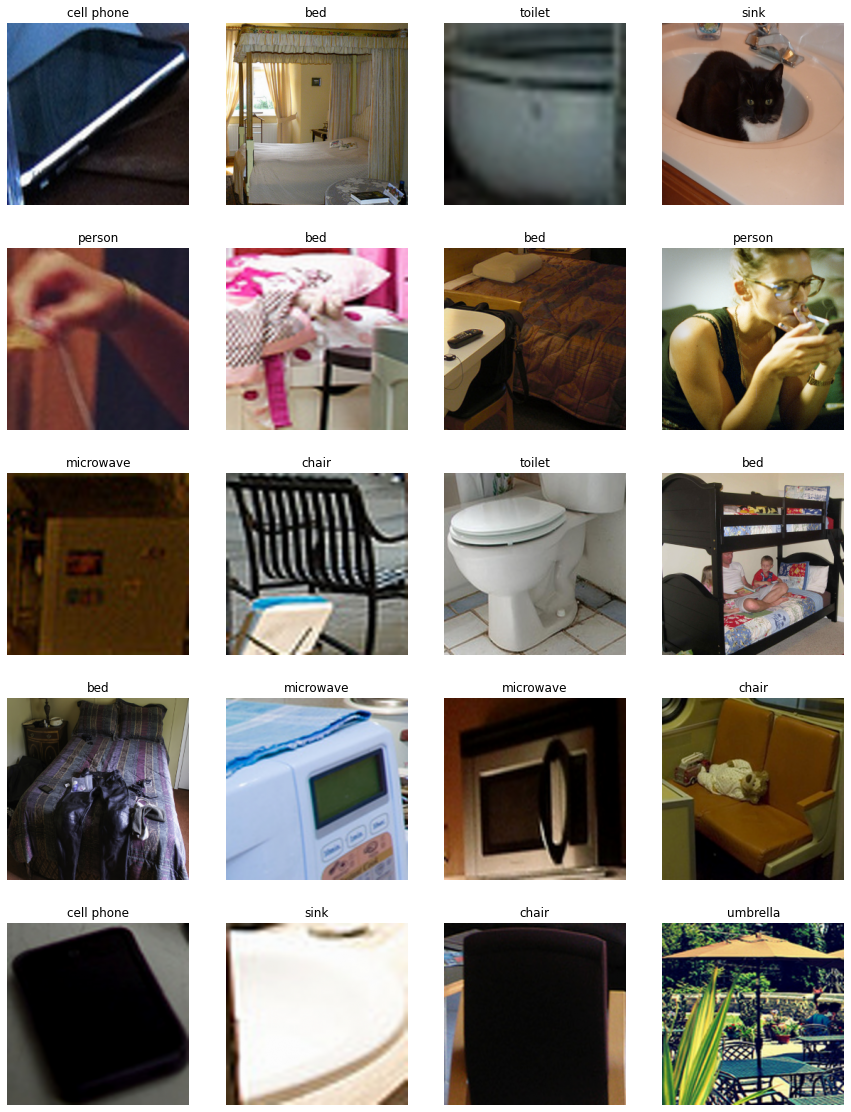

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 20))

# Visualize a few training images from each category
for i in range(5):
    for j in range(4):
        plt.subplot(5, 4, 4*i + j + 1)
        plt.imshow(x_train[4*i + j, :, :, :])
        plt.axis('off')
        plt.title(lab2cat[int(y_train[4*i + j])])

### CNN model Definition

In [13]:
# Prepare a keras CNN model for training
# Model configuration
batch_size = 4
img_height, img_width, img_num_channels = x_train.shape[1:]
input_shape = (img_height, img_width, img_num_channels)
loss_function = sparse_categorical_crossentropy
no_classes = 10
no_epochs = 1000
optimizer = Adam()
validation_split = 0.25
verbosity = 1
min_delta = 0.001

In [14]:
# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

# Add early stopping to the model
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=min_delta, verbose=verbosity, patience=10)

### Model Training

In [18]:
# Compile the model
model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=no_epochs, verbose=verbosity, validation_split=validation_split, callbacks=[es])

Train on 5802 samples, validate on 1935 samples
Epoch 1/1000
5802/5802 [==============================] - 40s 7ms/sample - loss: 2.2979 - accuracy: 0.1055 - val_loss: 2.3021 - val_accuracy: 0.0972
Epoch 2/1000
5802/5802 [==============================] - 33s 6ms/sample - loss: 2.2979 - accuracy: 0.1055 - val_loss: 2.3021 - val_accuracy: 0.0972
Epoch 3/1000
5802/5802 [==============================] - 37s 6ms/sample - loss: 2.2978 - accuracy: 0.1034 - val_loss: 2.3021 - val_accuracy: 0.0972
Epoch 4/1000
5802/5802 [==============================] - 32s 6ms/sample - loss: 2.2982 - accuracy: 0.1036 - val_loss: 2.3017 - val_accuracy: 0.0972
Epoch 5/1000
5802/5802 [==============================] - 32s 6ms/sample - loss: 2.2260 - accuracy: 0.1539 - val_loss: 2.1017 - val_accuracy: 0.2253
Epoch 6/1000
5802/5802 [==============================] - 32s 5ms/sample - loss: 2.0403 - accuracy: 0.2566 - val_loss: 1.9619 - val_accuracy: 0.2822
Epoch 7/1000
5802/5802 [==============================] - 

In [19]:
# Save model
model.save('obj-recog')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: obj-recog\assets


### Model Evaluation

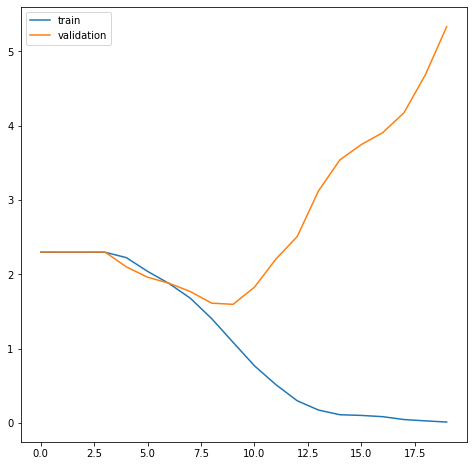

In [26]:
# Plot learning curves
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [21]:
# Estimate generalization performance of the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 0)
print("Test Loss:", test_loss)
print("Test accuracy", test_acc)

Test Loss: 5.279696496574146
Test accuracy 0.55400515


## Make predictions on Test Data

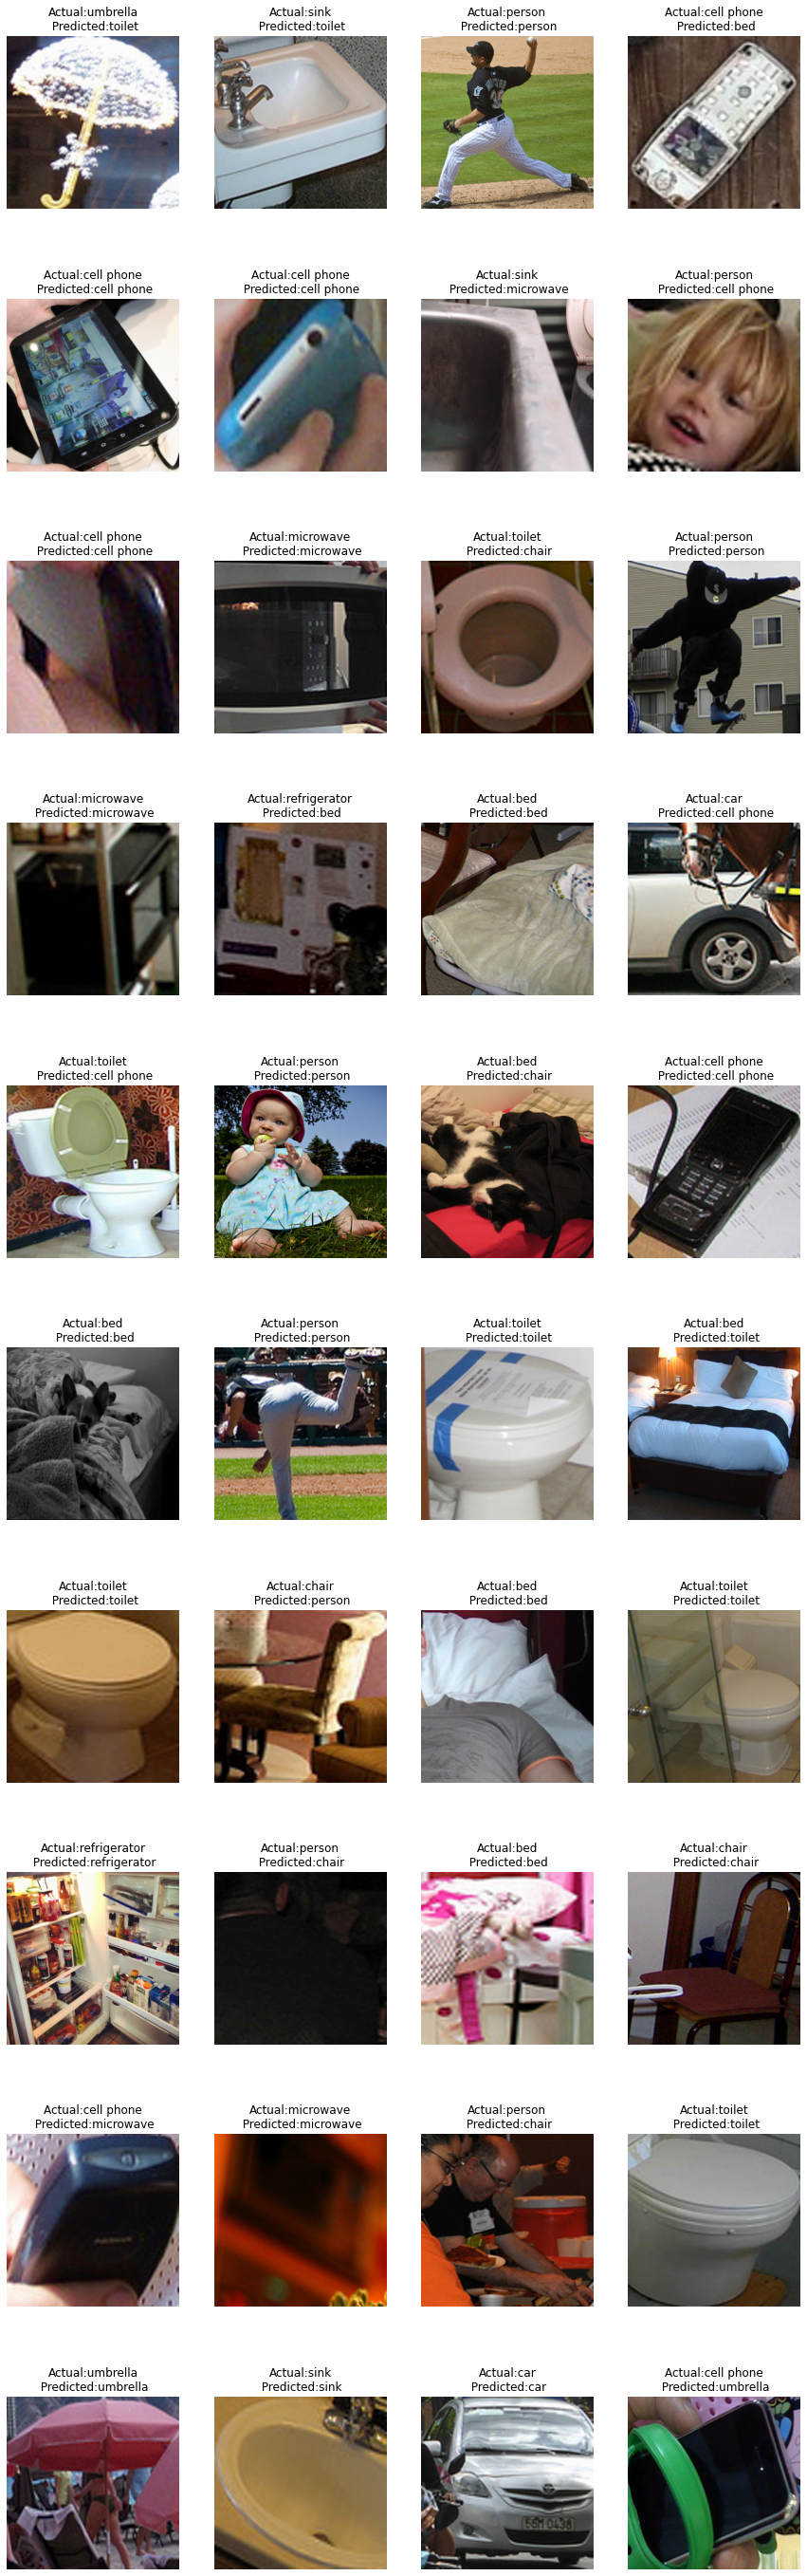

In [34]:
# Visualize a few predictions on test set
predictions = model.predict(x_test[:40])
prediction_classes = predictions.argmax(axis = -1)

plt.figure(figsize=(15, 50))
for i in range(10):
    for j in range(4):
        plt.subplot(10, 4, 4*i + j + 1)
        plt.imshow(x_test[4*i + j, :, :, :])
        plt.axis('off')
        plt.title('Actual:{}\n Predicted:{}'.format(lab2cat[int(y_test[4*i + j])], 
                lab2cat[prediction_classes[4*i + j]]))